# Euclidean Neural Networks: neural networks + representation theory

*ALL* operations are constructed to commute with group action D(g). Meaning all operations must satisfy the condition

$$
f(D(g)x, w) = D(g)f(x,w)
$$

where $g$ is an element of Euclidean symmetry


## Quick Recap on Group Theory


 Quick recap on Groups
 
 **$\mathbf{O(3)}$** allows all orthogonal matrices $det= \pm 1$. Includes reflections; relevant if mirror images are indistinguishable in your task (many classical shape problems). An $O(3)$ transform acts as $x\mapsto Rx$; no translation is included, so the origin stays put. $O(3)$ **preserves lengths and angles** and hence dot products; it preserves chirality **only** when restricted to **SO(3)**.
  
 $\mathbf{SO(3)}$ is the “special orthogonal group”: $R^\top R=I$ and $\det R = +1$. Orthogonality preserves lengths and angles, and $\det=+1$ rules out reflections (if $det = -1$ then you get the inversion of the image)
 
$E(3)$ is the group of all Euclidean isometries of $\mathbb{R}^3$: maps that preserve pairwise distance
$\mathbf{E(3)}=\mathbb{R}^3\rtimes \mathbf{O(3)}$ (full Euclidean group): translations + rotations + reflections. Some 3D vision datasets treat mirrored scenes as equivalent; then E(3) invariants are appropriate. So $E(3)$ **strictly contains $O(3)$**: it adds the ability to move the whole space without changing shape.

## Rotation and Translation 

The rotation/reflection part is a $3×3$ matrix $R$; $R$ must be *orthogonal* and for $SO(3)$ have a positive determinant. if $R$ isn’t orthogonal, lengths and angles will not be preserved and we've left the Euclidean group.

The translation is a $3$-vector $t$. 

For a proper rotation (no mirror flip), its required $R^\top R=I$ and $\det R=+1$. If we allow reflections, then we keep $R^\top R=I$ but permit $\det R=-1$ -this will mess up with enantiomers though-.

All the standard ways to build R—axis–angle (Rodrigues), quaternions, or QR/SVD orthonormalization—boil down to the same condition: R must be orthogonal and, for SO(3), have positive determinant. Translation is always $x\mapsto x+t$. Inversion through the origin is just $x\mapsto -x$, i.e., $R=-I$ (orthogonal with $\det=-1$).

#### Rodrigues' formula

A 3D rotation is fully determined by an axis u (a unit 3-vector) and an angle $\theta$.

"Rotate about the x-axis by $\theta$” means: keep the x-coordinate fixed, rotate the y–z plane. Choose $u=\mathbf{e}_x=(1,0,0)$

“Rotate about the y-axis by $\theta$” means: keep y fixed, rotate the x–z plane. Choose $u=\mathbf{e}_y=(0,1,0)$.

For the z-axis, $u=\mathbf{e}_z=(0,0,1)$.

Rodrigues formula turns $(u,\theta)$ into a rotation:
$$
R = I\cos\theta + (1-\cos\theta)\,uu^\top + [u]\times \sin\theta
$$

where $[u]\times$ is the skew matrix with $[u]_\times v = u\times v$.

With $u=\mathbf{e}_x$, this becomes the familiar

$$
R_x(\theta)=\begin{pmatrix}
1&0&0\\[2pt]0&\cos\theta&-\sin\theta\\[2pt]0&\sin\theta&\cos\theta
\end{pmatrix}.
$$

With $u=\mathbf{e}_y$,
$$
R_y(\theta)=\begin{pmatrix}
\cos\theta&0&\sin\theta\\[2pt]0&1&0\\[2pt]-\sin\theta&0&\cos\theta
\end{pmatrix}
$$
and so on

# Basics of RDKit

For the basics of RDkit [Start here](https://education.molssi.org/python-data-science-chemistry/rdkit_descriptors/rdkit.html) that's pretty much all you will probably need. 



## To write SMILES
Writing SMILES (string representation for molecules) manually is simple:

Each atom is written in sequence, and single bonds are implied:
```
C → CH4
CC → CH3–CH3
CCC → CH3–CH2–CH3
```
Use parentheses for branches:    
```
CC(C)C → isobutane
(the (C) means a CH3 branch on the second carbon) 
    CH3
     |
CH3-CH2-CH3
```


Double and triple bonds:
```
C=C → ethene
C#C → ethyne
```

Rings use numbers to show where atoms connect back:
```
C1CCCCC1 → cyclohexane
C1=CC=CC=C1 → benzene
```

Add heteroatoms directly:
```
CCO → ethanol
CC(=O)O → acetic acid
```

Aromatic atoms are lowercase:
```
c1ccccc1 → benzene
c1ccncc1 → pyridine
```

General rule: write the main chain, add branches with parentheses, add rings with numbers, use = and # for multiple bonds. Hydrogens are implied.


`AllChem.EmbedMolecule()` uses RDKit’s ETKDG algorithm (Experimental-Torsion Knowledge Distance Geometry):

1.	Distance geometry:

- 	Estimates upper and lower distance bounds between atoms based on connectivity and ideal bond lengths/angles.

 - Randomly generates a 3D coordinate set consistent with those bounds.

2.	Torsion knowledge (ETKDG):

-	Incorporates known distributions of torsion angles from crystal structures.

-	Produces much more realistic conformations than vanilla distance geometry.

3.	Force field minimization (optional):

-	By default, EmbedMolecule() just embeds; it doesn’t minimize energy.

-	To minimize (relax) the structure, you can do:

# Some helper functions

In [1]:
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import Draw, AllChem
import numpy as np 
import py3Dmol
# Some helper functions

def smiles_to_2D(smiles:str):
    # Displays the molecule in 2D
    mol = Chem.MolFromSmiles(smiles)
    mol_2d_fig = Draw.MolToImage(mol)
    display(mol_2d_fig)

def smiles_to_3D_interactive(smiles:str, add_hydrogens:bool=True):
    mol = Chem.MolFromSmiles(smiles)
    if add_hydrogens:
        mol = Chem.AddHs(mol)

    # Generate 3D conformer with MMFF optimization
    AllChem.EmbedMolecule(mol, AllChem.ETKDG()) # type: ignore
    AllChem.MMFFOptimizeMolecule(mol) # type: ignore

    block = Chem.MolToMolBlock(mol) # block is the data type for 3D viz

    viewer = py3Dmol.view(width=400, height=400)
    viewer.addModel(block, 'mol')
    viewer.setStyle({'stick': {}})
    viewer.zoomTo()
    
    display(viewer)


def get_3D_coords(smiles:str, optimize:bool=True, seed:int=42):
    try: mol = Chem.MolFromSmiles(smiles)
    except Exception as e: raise ValueError(f'Invalid Smiles raised exception{e}') 
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, randomSeed=seed)

    if optimize: AllChem.MMFFOptimizeMolecule(mol)  # MMFF94 force field

    conf = mol.GetConformer()

    coords = []
    for i, atom in enumerate( mol.GetAtoms()):
        pos = conf.GetAtomPosition(i)
        coords.append({
            'index': i,
            'symbol': atom.GetSymbol(),  # C, N, H, O ... 
            'x': pos.x,
            'y': pos.y, 
            'z': pos.z
        })

    return coords 

def smiles_to_3d_scatter(smiles:str, optimize:bool=True, seed:int=42):
    coords = get_3D_coords(smiles, optimize, seed) 
    # separate by element
    symbols = [a['symbol'] for a in coords]
    x = np.array([a['x'] for a in coords])
    y = np.array([a['y'] for a in coords])
    z = np.array([a['z'] for a in coords])

    # assign colors per element (simple scheme)
    color_map = {'C': 'black', 'O': 'red', 'N': 'blue', 'H': 'lightgray'}
    colors = [color_map.get(sym, 'orange') for sym in symbols]

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # scatter plot atoms
    ax.scatter(x, y, z, c=colors, s=100, edgecolor='k') # type: ignore

    # label atoms
    for a in coords:
        ax.text(a['x'], a['y'], a['z'], a['symbol'], fontsize=10, ha='center', va='center')

    # set equal aspect ratio
    max_range = (x.max()-x.min(), y.max()-y.min(), z.max()-z.min())
    max_range = max(max_range)
    mid = [np.mean(x), np.mean(y), np.mean(z)]
    ax.set_xlim(mid[0]-max_range/2, mid[0]+max_range/2)
    ax.set_ylim(mid[1]-max_range/2, mid[1]+max_range/2)
    ax.set_zlim(mid[2]-max_range/2, mid[2]+max_range/2)

    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    ax.set_title("3D Conformer")

    plt.show()

def coords_to_3d_scatter(coords:list):
    # separate by element
    symbols = [a['symbol'] for a in coords]
    x = np.array([a['x'] for a in coords])
    y = np.array([a['y'] for a in coords])
    z = np.array([a['z'] for a in coords])

    # assign colors per element (simple scheme)
    color_map = {'C': 'black', 'O': 'red', 'N': 'blue', 'H': 'lightgray'}
    colors = [color_map.get(sym, 'orange') for sym in symbols]

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # scatter plot atoms
    ax.scatter(x, y, z, c=colors, s=100, edgecolor='k') # type: ignore

    # label atoms
    for a in coords:
        ax.text(a['x'], a['y'], a['z'], a['symbol'], fontsize=10, ha='center', va='center')

    # set equal aspect ratio
    max_range = (x.max()-x.min(), y.max()-y.min(), z.max()-z.min())
    max_range = max(max_range)
    mid = [np.mean(x), np.mean(y), np.mean(z)]
    ax.set_xlim(mid[0]-max_range/2, mid[0]+max_range/2)
    ax.set_ylim(mid[1]-max_range/2, mid[1]+max_range/2)
    ax.set_zlim(mid[2]-max_range/2, mid[2]+max_range/2)

    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    ax.set_title("3D Conformer")

    plt.show()

# Rotation of a molecule using Rodrigues' formula

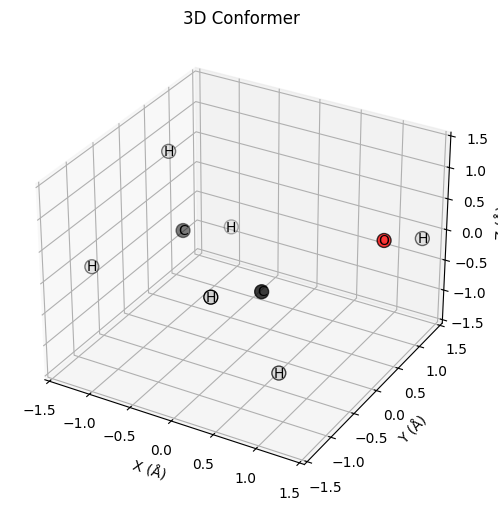

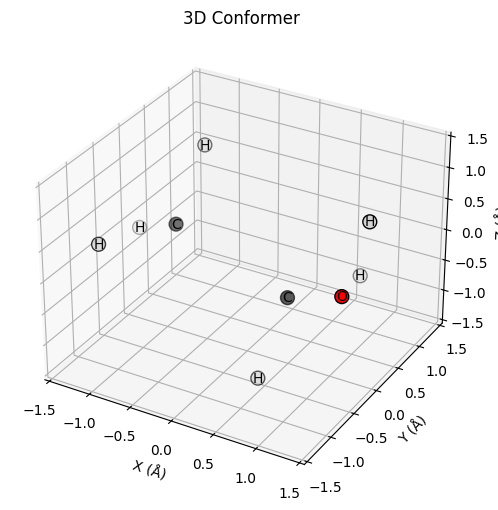

In [2]:
def R_axis_angle(axis:str, theta:int):
    """
    Rodrigues: u is 3-vector theta in radians returns R in SO(3).

    Arga:
        axis(str),  
        Theta is the angle in Degrees
    Rodrigues' formula
    R = I * cos(theta) + (1-cos(theta))*uu^T + [u]x(sin(theta)
    """
    axis = axis.lower()
    assert axis in 'xyz', 'Only X, Y or Z coordinates can be selected as axis'
    if axis=='x':
        u = np.array([1,0,0])
    if axis=='y':
        u = np.array([0,1,0])
    if axis=='z':
        u = np.array([0, 0, 1])
    theta = np.deg2rad(theta)
    nu = np.linalg.norm(u)
    if nu < 1e-12:
        return np.eye(3)
    # normalize
    u = u / nu
    ux, uy, uz = u
    K = np.array([[0, -uz, uy],
                  [uz, 0, -ux],
                  [-uy, ux, 0]], dtype=float)
    I = np.eye(3)
    return I * np.cos(theta) + (1 - np.cos(theta)) * np.outer(u, u) + np.sin(theta) * K

def apply_rotation(A, R):
    """Apply rotation to a matrix of XYZ coordinates using R matrix

    Args:
        A (matrix): Atom coordinates matrix shape (N, 3)
        R (matrix): Rotation matrix shape 3x3
    """
    assert np.abs((np.linalg.det(R))) == (1), 'det(R) must be equal to +1 or -1'
    return A @ R.T

cco_coords = get_3D_coords('CCO', seed=42) 
# plot cco 
coords_to_3d_scatter(cco_coords)

# get xyz coordiantes (cco_coords also contains atom and index)
x_coords = np.array([x['x'] for x in cco_coords])
y_coords = np.array([y['y'] for y in cco_coords])
z_coords = np.array([z['z'] for z in cco_coords])

atoms_matrix = np.array((x_coords, y_coords,z_coords)).T # [X,Y,Z] matrix, each row is one atom vector

# rotate 
theta = 90
R = R_axis_angle('x', theta)
#new coords
rotated_coords = apply_rotation(atoms_matrix, R)
#update coords with new_coords
for index, atom in enumerate(cco_coords):
    atom['x'], atom['y'], atom['z'] = rotated_coords[index]
# plot
coords_to_3d_scatter(cco_coords)

# Rotation + Translation

In [3]:
# We have to make sure the distances between atoms don't change
def inter_dists(X) ->np.ndarray:
    """For a matrix of 3D coordinates for every atom N calculates 
    returns a matrix of every pairwise euclidean distance
    Args:
        X: matrix of XYZ coordinates shape (N, 3) 
    Returns:
        np.ndarray: matrix  
    """
    assert X.ndim == 2 and X.shape[1] == 3, f"X must be (N,3), got {X.shape}"

    #TODO: This can be optimized computing only the upper or bottom triangle as d(i,j) == d(j,i) 
    inter_distance_matrix = np.zeros(shape=(X.shape[0], X.shape[0]))
    for i, i_atom_xyz in enumerate(X):
        for j, j_atom_xyz in enumerate(X):
            inter_distance_matrix[i,j] = np.linalg.norm(i_atom_xyz - j_atom_xyz)
    return inter_distance_matrix

inter_dists(atoms_matrix)

array([[0.        , 1.51460382, 2.40433692, 1.09497115, 1.09355909,
        1.09494758, 2.1634214 , 2.15643933, 2.55674788],
       [1.51460382, 0.        , 1.42017743, 2.15996821, 2.16124823,
        2.15870019, 1.09420647, 1.0938674 , 1.94811329],
       [2.40433692, 1.42017743, 0.        , 2.67687813, 3.35606104,
        2.66048635, 2.05226332, 2.04507861, 0.97242122],
       [1.09497115, 2.15996821, 2.67687813, 0.        , 1.77912673,
        1.75926241, 2.51347995, 3.06872374, 2.40684058],
       [1.09355909, 2.16124823, 3.35606104, 1.77912673, 0.        ,
        1.7802568 , 2.51749811, 2.50398908, 3.55961314],
       [1.09494758, 2.15870019, 2.66048635, 1.75926241, 1.7802568 ,
        0.        , 3.07275429, 2.50959383, 2.91568141],
       [2.1634214 , 1.09420647, 2.05226332, 2.51347995, 2.51749811,
        3.07275429, 0.        , 1.77450181, 2.30015375],
       [2.15643933, 1.0938674 , 2.04507861, 3.06872374, 2.50398908,
        2.50959383, 1.77450181, 0.        , 2.84389769],


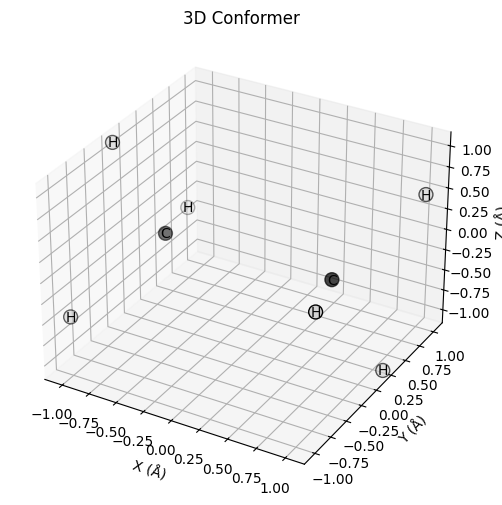

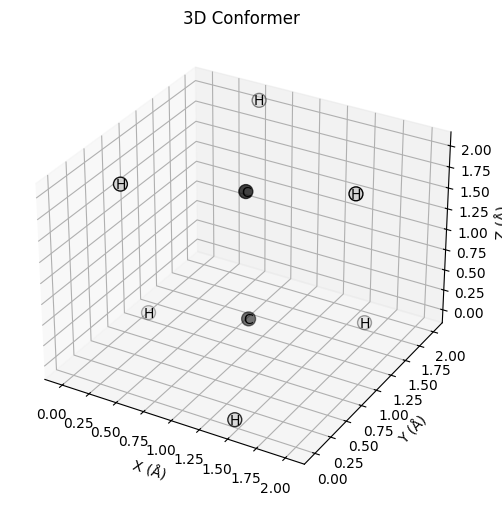

True

In [4]:
def translate(X, t):
    """Apply a translation t in R^3 to all rows of X: X' = X + t."""
    t = np.asarray(t).reshape(1, 3)
    return X + t

def rigid_transform(X, R, t):
    """Full E(3) action: X' = X R^T + t """
    return apply_rotation(X, R) + np.asarray(t).reshape(1, 3)


def se_3_transformation(X:np.ndarray, R:np.ndarray, t:np.ndarray):
    """SE(3) action X' = X R^T + t
    Any given R is transformed to have det(R) = +1
    """
    # This can destroy orthogonality, use SVD? 
    # if np.linalg.det(R) == -1:
    #     # multiply one row * -1 to change determinant to 1
    #     R[:, 1] = R[:, 1] * -1

    # return apply_rotation(X, R) + t.reshape(1, 3)
    pass


et_coords= get_3D_coords('CC' )
coords_to_3d_scatter(et_coords)
# get xyz coordiantes (cco_coords also contains atom and index)
x_coords = np.array([x['x'] for x in et_coords])
y_coords = np.array([y['y'] for y in et_coords])
z_coords = np.array([z['z'] for z in et_coords])

xyz_et_coords = np.array((x_coords, y_coords, z_coords)).T
et_inter_dists= inter_dists(xyz_et_coords)

R = R_axis_angle('y', 90)
t = np.array([1, 1, 1])

transformed_coords = rigid_transform(xyz_et_coords, R, t)
#update coords with new_coords
for index, atom in enumerate(et_coords):
    atom['x'], atom['y'], atom['z'] = transformed_coords[index]
# plot
et_inter_dists_after_transformation = inter_dists(transformed_coords)
coords_to_3d_scatter(et_coords)


## This should return True if rotation and translation worked properly
np.allclose(et_inter_dists, et_inter_dists_after_transformation)

## Testing out PyG

In [6]:
from typing import Any, Dict, List
import torch
from  torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.aggr import Aggregation
from torch_geometric.utils import add_self_loops, degree
from tqdm import tqdm


class GCNConv(MessagePassing):
        def __init__(self, aggr, in_channels, out_channels) -> None:
                super().__init__(aggr='add')
                self.lin = Linear(in_channels, out_channels, bias=False)
                self.bias = Parameter(torch.empty(out_channels))

                self.reset_parameters()

        def reset_parameters(self) -> None:
                self.lin.reset_parameters()
                self.bias.data.zero_()


        def forward(self, x, edge_index):
               # x has shape [N, in_channels] 
               # edge _index has shape [2, E]

               # for every node, we sum up all the feature vectors of all neighboring nodes
               #  but not the node itself (unless there are self-loops in the graph 
               # (that's why there's a self_loop function )
               pass


import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
data.validate() # This validates the edges

True

# GCNs

For these models the objective is to learn a function of features on a graph.

## Input

- A feature matrix of shape NxD (N: number of nodes, D: input features).
- A matrix showing how the nodes are connected, Normally is an adjancy matrix - a matrix of shape [2, N]-

## Output

- An NxF feature matrix, where N is the number of nodes and F the output features per node

## Layer

Each layer is a non-linear function 

$$
H^{(l+1)} = f(H^{(l)}, A)
$$

Note that $H^{0}$ is the input matrix ($X$) and $H^L$ is the output layer $Z$

$f$ can be any non-linear function like ReLU

### Example of a Layer

$$
f(H^{(l)}, A) = \sigma\left( AH^{(l)}W^{(l)}\right) \, ,
$$

Given we are multiplying A,H,W this means each nodes will have information on the node features from all surrounding nodes but not itslef.




In [7]:
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
dataset = Planetoid(root='/tmp/Cora', name='Cora')

# Simple two layer GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x) # non-linearity is not integrated in conv and needs to be called separatedly
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)


model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
data = dataset[0]

model.train()
for epoch in range(300):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

out

Processing...
Done!


tensor([[-1.6602e+01, -1.2711e+01, -1.5166e+01,  ..., -1.1186e+01,
         -1.3636e+01, -1.3390e+01],
        [-9.1986e+00, -2.8824e+01, -2.5929e+01,  ..., -1.0120e-04,
         -3.4018e+01, -2.2619e+01],
        [-8.0884e+00, -2.4459e+01, -2.1311e+01,  ..., -3.0716e-04,
         -2.6621e+01, -2.0145e+01],
        ...,
        [-3.4113e+00, -1.5939e-01, -5.8936e+00,  ..., -9.3456e+00,
         -3.3500e+00, -5.0485e+00],
        [-7.9458e+00, -9.5270e+00, -9.2312e+00,  ..., -3.7236e+00,
         -9.7916e+00, -1.2517e+01],
        [-9.7153e+00, -9.6713e+00, -7.7830e+00,  ..., -6.5615e+00,
         -8.9965e+00, -1.1656e+01]], grad_fn=<LogSoftmaxBackward0>)

# Datasets

Nodes (atoms):
- Minimal: atomic number Z (or one-hot of Z for common elements).
- Useful extras: valence, formal charge, aromatic flag, hybridization, ring membership, implicit H count.
- Edges (bonds):
- Minimal: undirected bond graph (single edge both ways).
- Useful extras: bond order (single/double/triple/aromatic), conjugation, ring flag.

## RDKIT

### How to build a valid input from SMILES  

## QM9

Can be downloaded from torch_geometric datasets. 
In PyG: data.x → [num_atoms, num_node_features]. 

In [18]:
from rdkit.Chem.Draw import IPythonConsole
import py3Dmol
from torch_geometric.data import Data
from tqdm import tqdm
from typing import List
import torch
from rdkit.Chem import AllChem
from rdkit import Chem
from torch_geometric.utils import one_hot

# IPythonConsole.drawMol3D(esomeprazole)
from rdkit import RDLogger
from rdkit.Chem.MolStandardize import rdMolStandardize
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)


from typing import List, Union
import torch
from torch_geometric.data import Data
from rdkit import Chem
import numpy as np

class DataTransform:
    def __init__(self):
        self.ATOM_MAP = {
                "H": 0,
                "C": 1,
                "N": 2,
                "O": 3,
                "F": 4,
                "P": 5,
                "S": 6,
                "Cl": 7,
                "Br": 8,
                "I": 9,
            }

        self.BOND_MAP = {
            'SINGLE': 0,
            'DOUBLE': 1, 
            'TRIPLE': 2,  
            'AROMATIC':3 
        }
        self.ATOM_ONEHOT = np.eye(len(self.ATOM_MAP), dtype=np.float32)
        self.BOND_ONEHOT = np.eye(len(self.BOND_MAP), dtype=np.float32)

    def smiles_to_graph(self, smiles: Union[List[str], str]):
        if isinstance(smiles, str):
            smiles = [smiles]

        graphs = []
        for idx, smi in tqdm(enumerate(smiles)):
            try:
                std_smi = rdMolStandardize.StandardizeSmiles(smi)
                mol = Chem.MolFromSmiles(std_smi)
                if mol is None:
                    continue
                mol = Chem.AddHs(mol)
                # 3D is optional; you only need coordinates if you will plot
                AllChem.EmbedMolecule(mol, AllChem.ETKDGv3())
                AllChem.MMFFOptimizeMolecule(mol)
                conf = mol.GetConformer()
                pos_matrix = np.asarray(conf.GetPositions(), dtype=np.float32)  # (N,3)
            except Exception:
                continue

            edge_index = []
            bond_types = []

            # node features
            atom_idx_mapping = [self.ATOM_MAP[a.GetSymbol()] for a in mol.GetAtoms()]
            x = torch.tensor(self.ATOM_ONEHOT[atom_idx_mapping], dtype=torch.float32)
            labels = {i: atom.GetSymbol() for i, atom in enumerate(mol.GetAtoms())}  #  useful for plotting later maps idx to atom symbol
            # edges and edge features (both directions => COO format )
            for b in mol.GetBonds():
                i = b.GetBeginAtomIdx()
                j = b.GetEndAtomIdx()
                bt = self.BOND_MAP[str(b.GetBondType())]
                edge_index.append((i, j))
                edge_index.append((j, i))
                bond_types.append(bt)
                bond_types.append(bt)

            if edge_index:
                ei = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # [2, E]
                edge_attr = torch.tensor(self.BOND_ONEHOT[bond_types], dtype=torch.float32)  # [E, F]
            else:
                ei = torch.empty((2, 0), dtype=torch.long)
                edge_attr = torch.empty((0, len(self.BOND_MAP)), dtype=torch.float32)

            data = Data(
                x=x,
                edge_index=ei,
                edge_attr=edge_attr,
                pos=torch.tensor(pos_matrix, dtype=torch.float32),  # shape [N,3]
                smi=smi,
                labels = labels,
                idx=idx,
            )
            graphs.append(data)

        return graphs
    
transform = DataTransform()

Converting SMILES into Graphs: 100%|██████████| 100/100 [00:01<00:00, 77.13it/s]


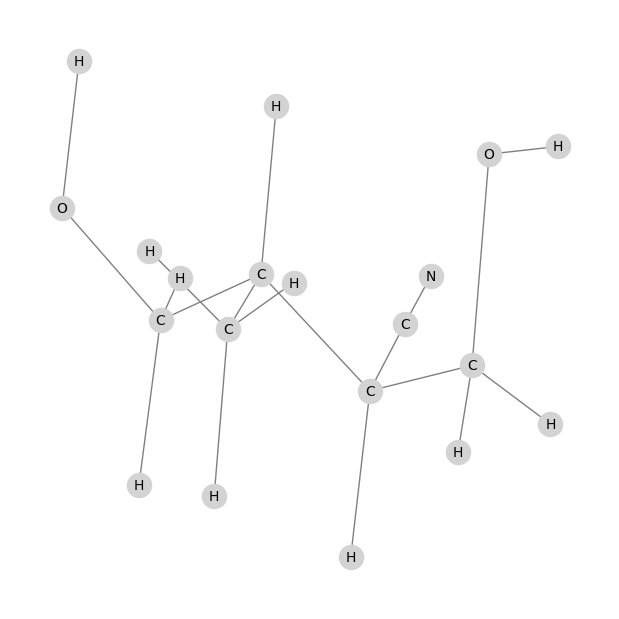

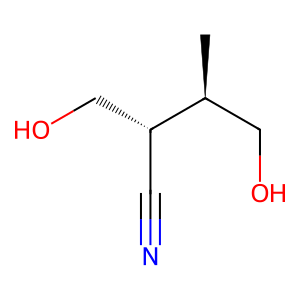

In [ ]:
import os
os.chdir('/Users/afloresep/side_projects/se3-diffusion/src')
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from utils import DataTransform
with open('/Users/afloresep/side_projects/se3-diffusion/data/smiles_strings.txt', 'r') as file: smiles_strings_qm9 = [line.split('\n')[0] for line in file]

transform = DataTransform()

graphs = transform.smiles_to_graph(smiles_strings_qm9[:100])


# Try some graph
data = graphs[3]
# Convert to a NetworkX graph
G = to_networkx(data, to_undirected=True)

# Use positions if they exist
pos = {i: data.pos[i][:2].tolist() for i in range(data.num_nodes)}  

plt.figure(figsize=(6,6))
nx.draw(
    G, pos,
    with_labels=False,
    node_color='lightgray',
    edge_color='gray',
    node_size=300
)
nx.draw_networkx_labels(G, pos, data.labels, font_size=10)
plt.show()

# compare to acutal molecule

from rdkit.Chem import Draw
from rdkit import Chem
Draw.MolToImage(Chem.MolFromSmiles(data.smi))